In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import pandas as pd
import pymc3 as pm
from quap import quap
import arviz as az
import statsmodels.api as sm
import math

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("Data/WaffleDivorce.csv", delimiter=";")

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

In [4]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [5]:
with pm.Model() as m_age_mrate:
    a = pm.Normal("a", 0, 0.2)
    b1 = pm.Normal("b1", 0, 0.5)
    b2 = pm.Normal("b2", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = a + b1 * data.Marriage_std + b2 * data.MedianAgeMarriage_std

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data.Divorce_std
    )
    prior_samples = pm.sample_prior_predictive()
    idata,dist = quap(vars=[a,b1,b2,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [6]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.000,0.097,-0.145,0.163
b1,-0.066,0.152,-0.305,0.182
b2,-0.614,0.153,-0.845,-0.359
sigma,0.786,0.078,0.658,0.909


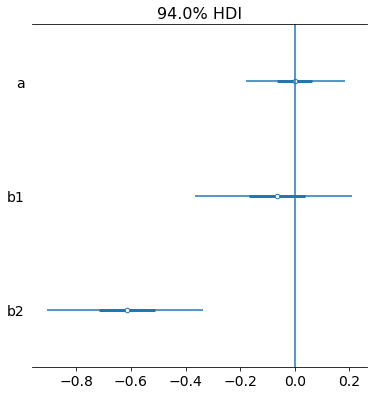

In [7]:
az.plot_forest(
    idata,
    var_names=["a","b1", "b2"],
)
plt.axvline(0)

In [2]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,11.630274,5.752928,5.769474
1,5.825454,2.468372,2.434044
2,8.229036,3.702573,3.691696
3,9.459327,4.300565,4.293709
4,10.185783,4.244319,4.282989


In [27]:
with pm.Model() as left_leg:
    a = pm.Normal("a", 10, 100)
    b_left = pm.Normal("b_left", 2, 10)
   

    sigma = pm.Exponential("sigma", 1)
    mu = a + b_left * d.leg_left

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    idata,dist = quap(vars=[a,b_left,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [25]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.885,0.258,0.475,1.302
b_left,2.010,0.057,1.919,2.100
sigma,0.568,0.040,0.506,0.633


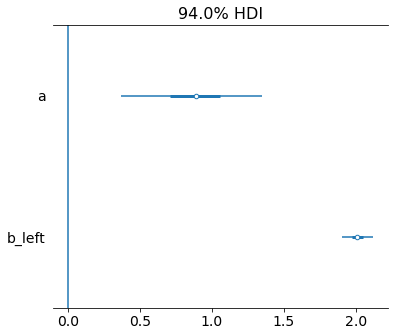

In [26]:
az.plot_forest(
    idata,
    var_names=["a","b_left"],
)
plt.axvline(0)

In [29]:
with pm.Model() as right_leg:
    a = pm.Normal("a", 10, 100)
    b_right = pm.Normal("b_right", 2, 10)
   

    sigma = pm.Exponential("sigma", 1)
    mu = a + b_right * d.leg_right

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    idata,dist = quap(vars=[a,b_right,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [30]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.882,0.261,0.466,1.299
b_right,2.010,0.057,1.913,2.095
sigma,0.568,0.040,0.506,0.632


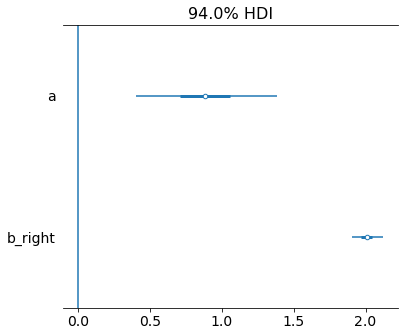

In [31]:
az.plot_forest(
    idata,
    var_names=["a","b_right"],
)
plt.axvline(0)

In [33]:
with pm.Model() as both_legs:
    a = pm.Normal("a", 10, 100)
    b_left = pm.Normal("b_left", 2, 10)
    b_right = pm.Normal("b_right", 2, 10)
    sigma = pm.Exponential("sigma", 1)
    
    mu = a + b_left * d.leg_left + b_right * d.leg_right
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)

    idata,dist = quap(vars=[a,b_left,b_right,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [34]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.886,0.259,0.479,1.307
b_left,1.305,1.950,-1.852,4.408
b_right,0.705,1.949,-2.438,3.817
sigma,0.567,0.040,0.503,0.630


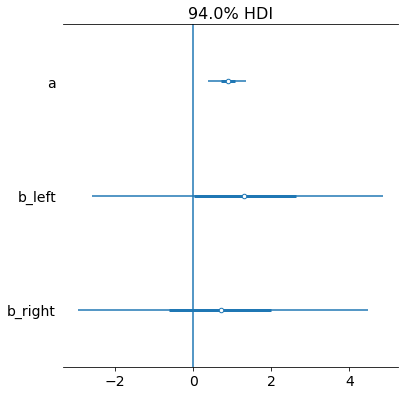

In [35]:
az.plot_forest(
    idata,
    var_names=["a","b_left","b_right"],
)
plt.axvline(0)

In [9]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
h0,10.21,1.97,6.90,13.91
h1,14.37,2.59,9.54,18.44
treatment,0.50,0.50,0.00,1.00
fungus,0.28,0.45,0.00,1.00


In [12]:
treatment


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [43]:
with pm.Model() as m6_6:
    p = pm.Lognormal("p", 0, 0.25)
    sigma = pm.Exponential("sigma", 1)
    
    mu = h0*p
    h1 = pm.Normal("height", mu=mu, sigma=sigma, observed=d.h1)

    idata,dist = quap(vars=[p,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [46]:
az.summary(idata, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
p,1.41,0.02,1.39,1.44
sigma,1.77,0.12,1.57,1.97


In [49]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    b1 = pm.Normal("b1", 0, 0.5)
    b2 = pm.Normal("b2", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    p = a + b1 * d.treatment + b2 * d.fungus
    mu = p * d.h0
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)

    idata,dist = quap(vars=[a,b1,b2,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

az.summary(idata, kind="stats",round_to=2)

,mean,sd,hdi_3%,hdi_97%
a,1.45,0.03,1.39,1.51
b1,0.03,0.04,-0.03,0.10
b2,-0.21,0.04,-0.28,-0.13
sigma,1.41,0.10,1.22,1.59


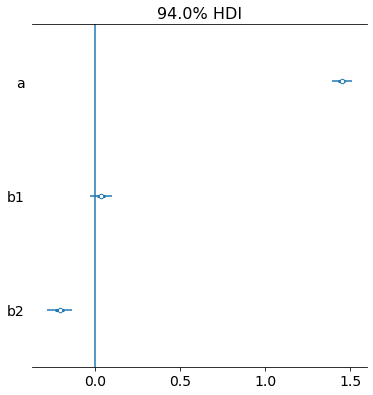

In [50]:
az.plot_forest(
    idata,
    var_names=["a","b1","b2"],
)
plt.axvline(0)